In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, execute
from qiskit.visualization import plot_distribution, plot_bloch_multivector, array_to_latex, plot_histogram
from qiskit.extensions import Initialize, UnitaryGate
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.result import marginal_counts
from qiskit import quantum_info
from qiskit.circuit import Parameter

In [2]:
# Función que genera los 4 estados de Bell
def crear_estado_werner(circuito, qubits, parameter):
     #Define el generador de números aleatorios con una ponderación de w
    circuito.ry(parameter, qubits[0])
    circuito.cx(qubits[0], qubits[2])
    
    #Genera estado máximamente mezclado
    circuito.h(qubits[0])
    
    circuito.x(qubits[2])
    circuito.ch(qubits[2], qubits[1])
    circuito.ccx(qubits[0],qubits[2],qubits[3])
    circuito.ccx(qubits[1],qubits[2],qubits[4])
    
    #Genera estado entrelazado
    circuito.x(qubits[2])
    circuito.cx(qubits[2],qubits[1])
    circuito.ccx(qubits[0],qubits[2],qubits[1])
    circuito.x(qubits[2])
            
def alice_operaciones(circuito, qubits):
    circuito.cx(qubits[0], qubits[1])
    circuito.h(qubits[0])

def medir_luego_enviar(circuito, qubits, bit1, bit2):
    circuito.measure(qubits[0], bit1)
    circuito.measure(qubits[1], bit2)
    
def bob_operaciones(circuito, qubits, bit1, bit2, bell): 
    circuito.x(qubits[0]).c_if(bit2, not int(bell[1])) #El cbit1 es resultado de medir q0
    circuito.z(qubits[0]).c_if(bit1, not int(bell[0]))#El cbit2 es resultado de medir q1
    
def swapping(w,bell_state="11"):
    theta = 2*np.arcsin(w)
    qubits = QuantumRegister(10, name="q")
    cbit1 = ClassicalRegister(1, name="cbitA") 
    cbit2 = ClassicalRegister(1, name="cbitB")
    cbit3 = ClassicalRegister(1, name="cbitC") 
    cbit4 = ClassicalRegister(1, name="cbitD") 
    circuito = QuantumCircuit(qubits, cbit1, cbit2, cbit3, cbit4)
    
    #Inicializamos pares entrelazados:
    crear_estado_werner(circuito, [0,1,2,3,4], theta[0])
    crear_estado_werner(circuito, [5,6,7,8,9], theta[1])
    
    circuito.barrier()
    
    #Alice realiza operaciones con sus qubits
    alice_operaciones(circuito, [1,5])
    
    ####
    #Alice mide sus qúbits y envía por whatsapp a Bob
    medir_luego_enviar(circuito, [1,5], cbit2, cbit3)
    circuito.barrier()
    
    #Bob recibe bits de Alice y efectúa algunas operaciones
    bob_operaciones(circuito, [6], cbit2, cbit3, bell_state)
 
    
    circuito.cx(qubits[0], qubits[6])
    circuito.h(qubits[0])
   
    circuito.measure(qubits[0], cbit1)
    circuito.measure(qubits[6], cbit4)

    return [circuito, qubits]

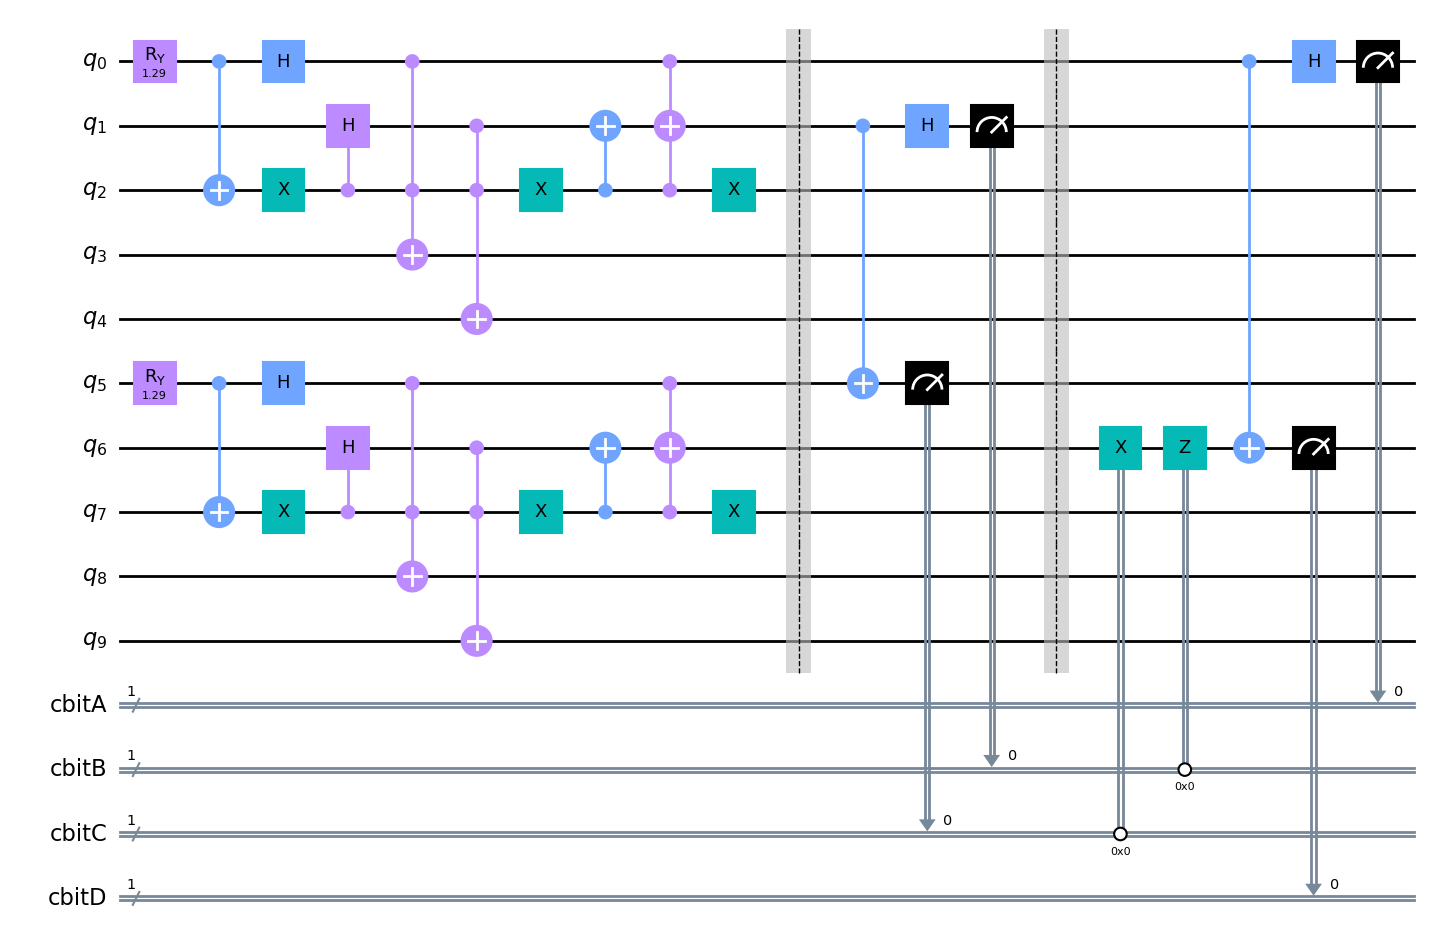

In [3]:
qc, qubits = swapping([3/5,3/5], "11")
qc.draw(output="mpl")

In [4]:
sim = Aer.get_backend("aer_simulator") 
output = execute(qc, sim)
counts = output.result().get_counts(qc)

In [5]:
qubit_counts = [marginal_counts(counts, [bit]) for bit in range(4)]

Text(0.5, 0, 'Classical State')

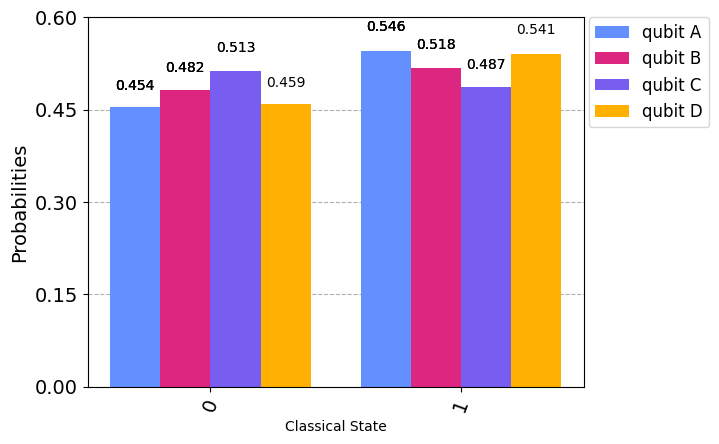

In [6]:
import matplotlib.pyplot as plt

grafica = plt.subplot()
legendas = ["qubit A","qubit B","qubit C","qubit D"]
plot_distribution(qubit_counts, ax=grafica, legend=legendas)
grafica.set_ylabel('Probabilities')
grafica.set_xlabel('Classical State')

In [7]:
image = qc.draw(output="mpl")

In [8]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

# Convierte la imagen a un objeto de bytes
buf = BytesIO()
image.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)
im = Image.open(buf)

# Convierte la imagen a formato RGB
im = im.convert('RGB')

# Guarda la imagen en formato PDF
im.save('circuito2.pdf', 'PDF', resolution=100.0)